In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import cv2
import shutil

# ===============================
# INPUT DATASET ROOT
# ===============================
input_root = "/kaggle/input/datasets/nadandan/angiophoto"

# ===============================
# OUTPUT DATASET ROOT (same name)
# ===============================
output_root = "/kaggle/working/angiophoto"

# Remove old output if exists (safe rerun)
if os.path.exists(output_root):
    shutil.rmtree(output_root)

# Copy entire dataset structure first
shutil.copytree(input_root, output_root)

print("📁 Dataset structure copied.")

# ===============================
# APPLY CLAHE ONLY TO imagesTr
# ===============================
imagesTr_path = os.path.join(output_root, "AngioPHOTO", "imagesTr")

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for fn in os.listdir(imagesTr_path):
    if not fn.lower().endswith(".png"):
        continue

    img_path = os.path.join(imagesTr_path, fn)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print("⚠ Skipping:", fn)
        continue

    img_clahe = clahe.apply(img)

    # Overwrite image in copied dataset
    cv2.imwrite(img_path, img_clahe)

print("✅ CLAHE applied to imagesTr.")
print("🎉 New dataset ready at:", output_root)

In [ ]:
import cv2
from pathlib import Path

DATA_ROOT = Path("/kaggle/working/angiophoto/AngioPHOTO")
IMAGES_DIR = DATA_ROOT / "imagesTr"
LABELS_DIR = DATA_ROOT / "labelsTr"

TARGET_SIZE = (256, 256)  # (width, height)

count = 0

for img_path in sorted(IMAGES_DIR.glob("*_0000.png")):
    
    case_id = img_path.stem.replace("_0000", "")
    lbl_path = LABELS_DIR / f"{case_id}.png"

    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(str(lbl_path), cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        print(f"⚠ Skipping {case_id}")
        continue

    # Resize image (safe for grayscale images)
    img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)

    # Resize mask (VERY IMPORTANT: use NEAREST)
    mask_resized = cv2.resize(mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)

    # Overwrite
    cv2.imwrite(str(img_path), img_resized)
    cv2.imwrite(str(lbl_path), mask_resized)

    print(f"✅ {case_id}: {img.shape} → {img_resized.shape}")
    count += 1

print(f"\nDone. Resized {count} image-mask pairs to 256x256.")

In [ ]:
!pip -q install albumentations

In [ ]:
import cv2
import numpy as np
from pathlib import Path
import albumentations as A

DATA_ROOT = Path("/kaggle/working/angiophoto/AngioPHOTO")
IMAGES_DIR = DATA_ROOT / "imagesTr"
LABELS_DIR = DATA_ROOT / "labelsTr"

OUT_ROOT = Path("/kaggle/working/angiophoto/AngioPHOTO_aug")
OUT_IMAGES = OUT_ROOT / "imagesTr"
OUT_LABELS = OUT_ROOT / "labelsTr"
OUT_IMAGES.mkdir(parents=True, exist_ok=True)
OUT_LABELS.mkdir(parents=True, exist_ok=True)

# ✅ FIXED augmentation pipeline (safe for segmentation masks)
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),

    # Use Affine instead of ShiftScaleRotate and FORCE nearest for mask
    A.Affine(
        translate_percent=(-0.05, 0.05),
        scale=(0.90, 1.10),
        rotate=(-15, 15),
        shear=(-5, 5),
        interpolation=cv2.INTER_LINEAR,          # image interpolation
        mask_interpolation=cv2.INTER_NEAREST,    # ✅ CRITICAL
        cval=0,
        cval_mask=0,
        p=0.8
    ),

    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(p=0.2),
])

N_AUG_PER_IMAGE = 2  # how many augmented copies per original

# copy originals first (optional)
for img_path in sorted(IMAGES_DIR.glob("*_0000.png")):
    case_id = img_path.stem.replace("_0000", "")
    lbl_path = LABELS_DIR / f"{case_id}.png"

    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(str(lbl_path), cv2.IMREAD_GRAYSCALE)
    if img is None or mask is None:
        continue

    # OPTIONAL: enforce binary (0/255) for originals too (recommended)
    mask = (mask > 0).astype(np.uint8) * 255

    cv2.imwrite(str(OUT_IMAGES / img_path.name), img)
    cv2.imwrite(str(OUT_LABELS / lbl_path.name), mask)

# create augmented copies with new IDs
def extract_id(stem):
    return int(stem.split("_")[-1])  # expects angio_0001

existing_ids = []
for img_path in sorted(IMAGES_DIR.glob("*_0000.png")):
    case_id = img_path.stem.replace("_0000", "")
    existing_ids.append(extract_id(case_id))
next_id = max(existing_ids) + 1 if existing_ids else 1

written = 0
for img_path in sorted(IMAGES_DIR.glob("*_0000.png")):
    case_id = img_path.stem.replace("_0000", "")
    lbl_path = LABELS_DIR / f"{case_id}.png"

    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(str(lbl_path), cv2.IMREAD_GRAYSCALE)
    if img is None or mask is None:
        continue

    # OPTIONAL: ensure binary before augmentation
    mask = (mask > 0).astype(np.uint8) * 255

    for k in range(N_AUG_PER_IMAGE):
        out = aug(image=img, mask=mask)
        img_aug = out["image"]
        mask_aug = out["mask"]

        # ✅ OPTIONAL BUT RECOMMENDED: re-binarize after transforms
        mask_aug = (mask_aug > 0).astype(np.uint8) * 255

        new_case = f"angio_{next_id:04d}"
        cv2.imwrite(str(OUT_IMAGES / f"{new_case}_0000.png"), img_aug)
        cv2.imwrite(str(OUT_LABELS / f"{new_case}.png"), mask_aug)

        next_id += 1
        written += 1

print(f"Done. Wrote {written} augmented pairs into: {OUT_ROOT}")

In [ ]:
import cv2, numpy as np
from pathlib import Path

LB = Path("/kaggle/working/angiophoto/AngioPHOTO_aug/labelsTr")
vals = set()
for p in LB.glob("*.png"):
    m = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    vals.update(np.unique(m).tolist())
print("Unique mask values:", sorted(vals))

In [ ]:
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path("/kaggle/working/angiophoto/AngioPHOTO_aug")
IM = ROOT/"imagesTr"
LB = ROOT/"labelsTr"

all_imgs = sorted(IM.glob("*_0000.png"))

for _ in range(5):  # show 5 random examples
    img_path = random.choice(all_imgs)
    case_id = img_path.stem.replace("_0000","")
    msk_path = LB / f"{case_id}.png"

    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(str(msk_path), cv2.IMREAD_GRAYSCALE)

    # make sure same shape
    assert img.shape == msk.shape, (img.shape, msk.shape)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title(case_id+" image"); plt.imshow(img, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,2); plt.title("mask"); plt.imshow(msk, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,3); plt.title("overlay"); plt.imshow(img, cmap="gray"); plt.imshow(msk, alpha=0.35); plt.axis("off")
    plt.show()

In [ ]:
import shutil

# Path to the folder you want to download
folder_to_zip = "/kaggle/working/angiophoto"

# Name of the zip file (without .zip)
zip_path = "/kaggle/working/angiophotoAUG"

# Create zip file
shutil.make_archive(zip_path, 'zip', folder_to_zip)

print("✅ Zip file created at:", zip_path + ".zip")

In [ ]:
import random
import shutil
from pathlib import Path

# Source dataset (augmented one)
SRC_ROOT = Path("/kaggle/working/angiophoto/AngioPHOTO_aug")
IMAGES_DIR = SRC_ROOT / "imagesTr"
LABELS_DIR = SRC_ROOT / "labelsTr"

# Output split folder
OUT_ROOT = Path("/kaggle/working/angiophoto/AngioPHOTO_split")
TR_IMAGES = OUT_ROOT / "imagesTr"
TR_LABELS = OUT_ROOT / "labelsTr"
TS_IMAGES = OUT_ROOT / "imagesTs"
TS_LABELS = OUT_ROOT / "labelsTs"

for p in [TR_IMAGES, TR_LABELS, TS_IMAGES, TS_LABELS]:
    p.mkdir(parents=True, exist_ok=True)

# Collect all cases
all_images = sorted(IMAGES_DIR.glob("*_0000.png"))
cases = [p.stem.replace("_0000", "") for p in all_images]

# Shuffle
random.seed(42)  # reproducible
random.shuffle(cases)

# Split index
split_idx = int(0.8 * len(cases))
train_cases = cases[:split_idx]
test_cases = cases[split_idx:]

print(f"Total cases: {len(cases)}")
print(f"Train: {len(train_cases)}")
print(f"Test : {len(test_cases)}")

# Copy files
for case_id in train_cases:
    shutil.copy(IMAGES_DIR / f"{case_id}_0000.png", TR_IMAGES)
    shutil.copy(LABELS_DIR / f"{case_id}.png", TR_LABELS)

for case_id in test_cases:
    shutil.copy(IMAGES_DIR / f"{case_id}_0000.png", TS_IMAGES)
    shutil.copy(LABELS_DIR / f"{case_id}.png", TS_LABELS)

print("✅ Done splitting dataset.")

In [ ]:
import shutil
from pathlib import Path

# Your split dataset
SRC = Path("/kaggle/working/angiophoto/AngioPHOTO_split")

# nnU-Net target dataset folder
DST = Path("/kaggle/working/nnUNet_raw/Dataset001_AngioPHOTO")

# Create nnU-Net folders
(DST / "imagesTr").mkdir(parents=True, exist_ok=True)
(DST / "labelsTr").mkdir(parents=True, exist_ok=True)
(DST / "imagesTs").mkdir(parents=True, exist_ok=True)

# Copy training images + labels
for f in (SRC / "imagesTr").glob("*.png"):
    shutil.copy2(f, DST / "imagesTr" / f.name)

for f in (SRC / "labelsTr").glob("*.png"):
    shutil.copy2(f, DST / "labelsTr" / f.name)

# Copy test images
for f in (SRC / "imagesTs").glob("*.png"):
    shutil.copy2(f, DST / "imagesTs" / f.name)

print("✅ Copied split dataset into nnU-Net structure:")
print(DST)

In [ ]:
import json
from pathlib import Path

# Path to final nnU-Net dataset folder
DATASET_ROOT = Path("/kaggle/working/nnUNet_raw/Dataset001_AngioPHOTO")

imagesTr = DATASET_ROOT / "imagesTr"
labelsTr = DATASET_ROOT / "labelsTr"
imagesTs = DATASET_ROOT / "imagesTs"

# Count training cases
training_cases = sorted(imagesTr.glob("*_0000.png"))

dataset_json = {
    "channel_names": {
        "0": "angiogram"
    },
    "labels": {
        "background": 0,
        "vessel": 1
    },
    "numTraining": len(training_cases),
    "file_ending": ".png"
}

# Save dataset.json
with open(DATASET_ROOT / "dataset.json", "w") as f:
    json.dump(dataset_json, f, indent=4)

print("✅ dataset.json created")
print("Number of training cases:", len(training_cases))

In [ ]:
!git clone https://github.com/MIC-DKFZ/nnUNet.git

In [ ]:
%cd nnUNet
!ls
!pip install -e .

In [ ]:
import os

os.environ["nnUNet_raw"] = "/kaggle/working/nnUNet_raw"
os.environ["nnUNet_preprocessed"] = "/kaggle/working/nnUNet_preprocessed"
os.environ["nnUNet_results"] = "/kaggle/working/nnUNet_results"

print("Environment variables set ✅")

!mkdir -p /kaggle/working/nnUNet_preprocessed
!mkdir -p /kaggle/working/nnUNet_results
!ls /kaggle/working/nnUNet_raw

In [ ]:
!nnUNetv2_plan_and_preprocess -d 1 --verify_dataset_integrity

In [ ]:
import cv2
import numpy as np
from pathlib import Path

LABELS_TR = Path("/kaggle/working/nnUNet_raw/Dataset001_AngioPHOTO/labelsTr")

converted = 0
for p in LABELS_TR.glob("*.png"):
    m = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if m is None:
        print("⚠ failed to read:", p.name)
        continue

    # convert to 0/1
    m01 = (m > 0).astype(np.uint8)

    cv2.imwrite(str(p), m01)
    converted += 1

print(f"✅ Converted {converted} masks to 0/1 in labelsTr")

In [ ]:
!nnUNetv2_plan_and_preprocess -d 1 --verify_dataset_integrity

In [ ]:
!nnUNetv2_train Dataset001_AngioPHOTO 2d 0

In [ ]:
!nnUNetv2_predict \
-i /kaggle/working/nnUNet_raw/Dataset001_AngioPHOTO/imagesTs \
-o /kaggle/working/predictions \
-d Dataset001_AngioPHOTO \
-c 2d \
-f 0

In [1]:
import os
os.environ["nnUNet_raw"] = "/kaggle/working/nnUNet_raw"
os.environ["nnUNet_preprocessed"] = "/kaggle/working/nnUNet_preprocessed"
os.environ["nnUNet_results"] = "/kaggle/working/nnUNet_results"
print("✅ env set")

✅ env set


In [2]:
!find /kaggle/working/nnUNet_results -type f \( -name "checkpoint_best.pth" -o -name "checkpoint_final.pth" \)

/kaggle/working/nnUNet_results/Dataset001_AngioPHOTO/nnUNetTrainer__nnUNetPlans__2d/fold_0/checkpoint_best.pth


In [5]:
!ls -lh /kaggle/working/nnUNet_results/Dataset001_AngioPHOTO/nnUNetTrainer__nnUNetPlans__2d/fold_0/

total 466M
-rw-r--r-- 1 root root 209M Feb 27 18:30 checkpoint_best.pth
-rw-r--r-- 1 root root 256M Feb 27 18:15 checkpoint_latest.pth
-rw-r--r-- 1 root root 9.2K Feb 27 18:25 debug.json
-rw-r--r-- 1 root root 449K Feb 27 18:30 progress.png
-rw-r--r-- 1 root root 316K Feb 27 18:24 training_log_2026_2_27_13_30_46.txt
-rw-r--r-- 1 root root 7.9K Feb 27 18:30 training_log_2026_2_27_18_25_17.txt


In [6]:
!nnUNetv2_predict \
  -i /kaggle/working/nnUNet_raw/Dataset001_AngioPHOTO/imagesTs \
  -o /kaggle/working/predictions_fold0 \
  -d Dataset001_AngioPHOTO \
  -c 2d \
  -f 0 \
  -chk checkpoint_latest.pth


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 18 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 18 cases that I would like to predict

Predicting angio_0004:
perform_everything_on_device: True
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]
sending off prediction to background worker for resampling and export
done with angio_0004

Predicting angio_0005:
perform_everything_on_device: True
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.82it/s]
sending off prediction to background worker for resampling and

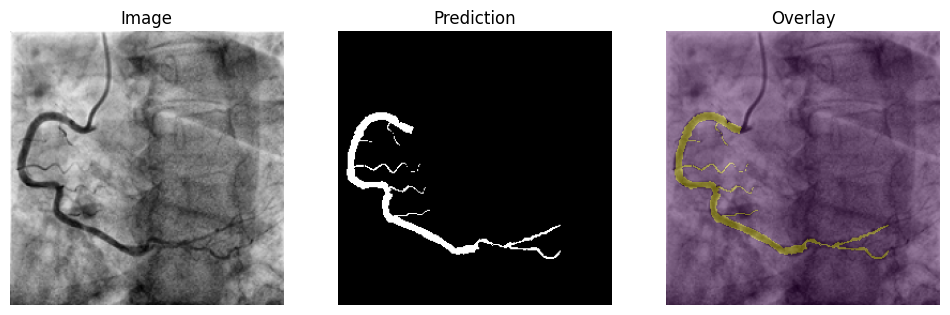

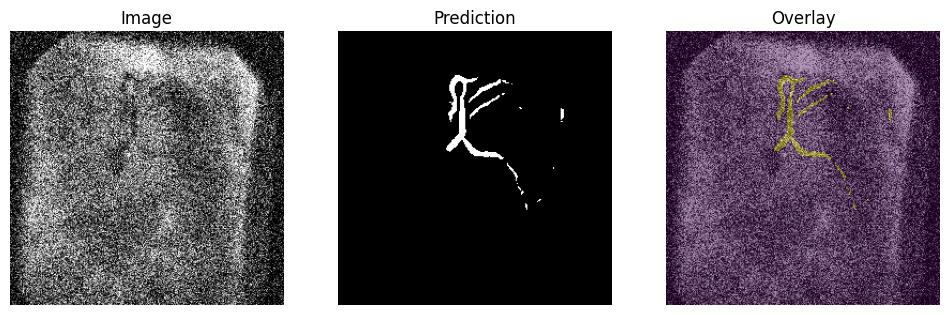

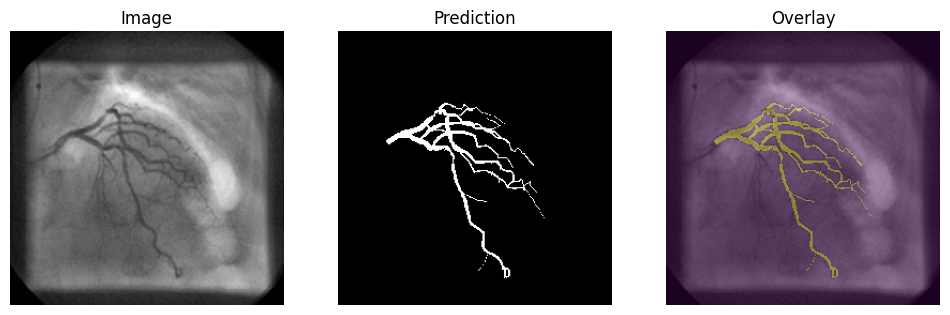

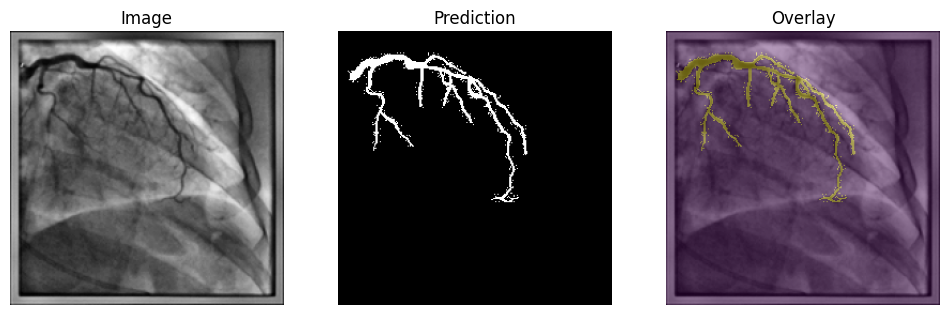

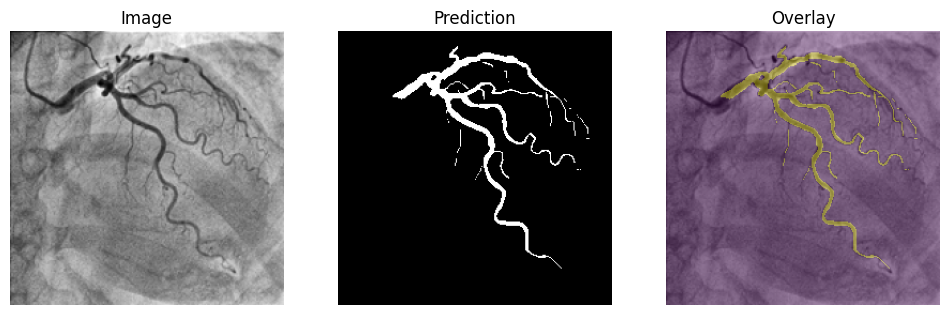

In [7]:
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
IMG_DIR = Path("/kaggle/working/nnUNet_raw/Dataset001_AngioPHOTO/imagesTs")
PRED_DIR = Path("/kaggle/working/predictions_fold0")

images = sorted(IMG_DIR.glob("*_0000.png"))

for _ in range(5):  # show 5 random examples
    img_path = random.choice(images)
    case_id = img_path.stem.replace("_0000", "")
    
    pred_path = PRED_DIR / f"{case_id}.png"
    
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    pred = cv2.imread(str(pred_path), cv2.IMREAD_GRAYSCALE)

    if pred is None:
        print("Prediction not found for:", case_id)
        continue

    plt.figure(figsize=(12,4))
    
    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    
    plt.subplot(1,3,2)
    plt.title("Prediction")
    plt.imshow(pred, cmap="gray")
    plt.axis("off")
    
    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(img, cmap="gray")
    plt.imshow(pred, alpha=0.4)
    plt.axis("off")
    
    plt.show()

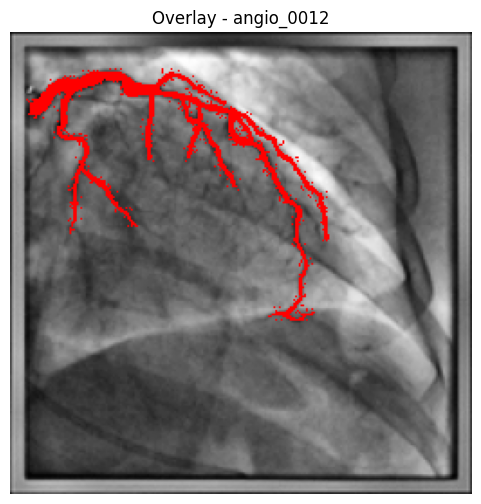

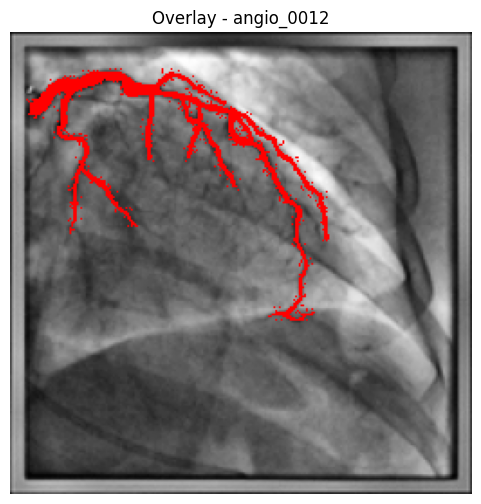

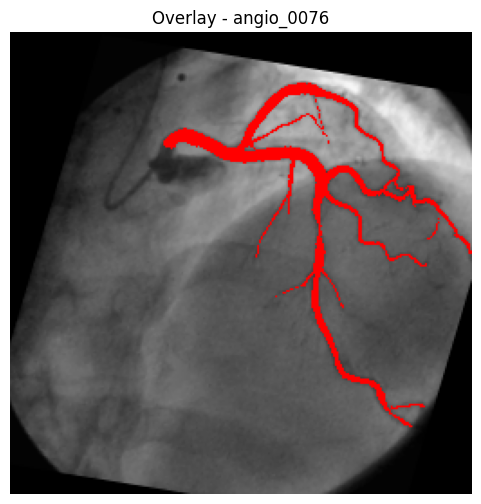

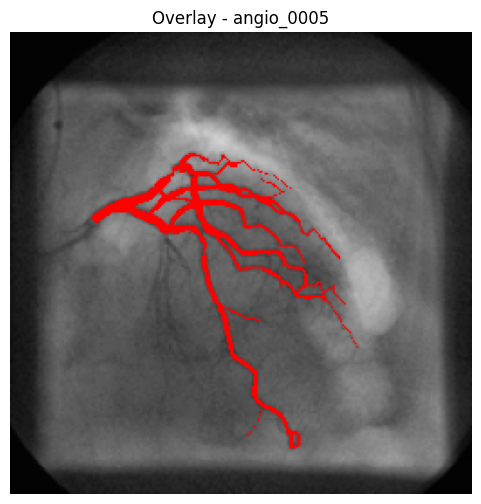

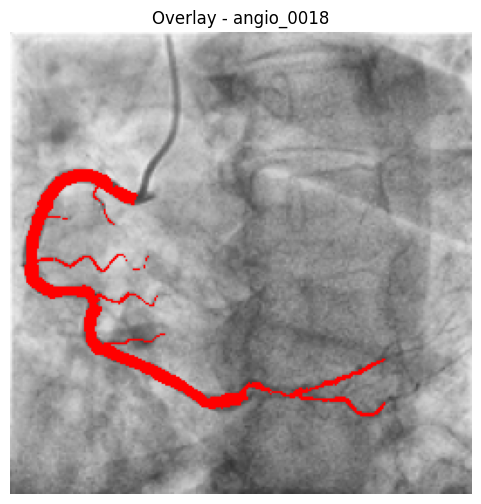

In [8]:
import numpy as np

for _ in range(5):
    img_path = random.choice(images)
    case_id = img_path.stem.replace("_0000", "")
    pred_path = PRED_DIR / f"{case_id}.png"

    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    pred = cv2.imread(str(pred_path), cv2.IMREAD_GRAYSCALE)

    if pred is None:
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Make mask red
    img_rgb[pred > 0] = [255, 0, 0]

    plt.figure(figsize=(6,6))
    plt.title(f"Overlay - {case_id}")
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

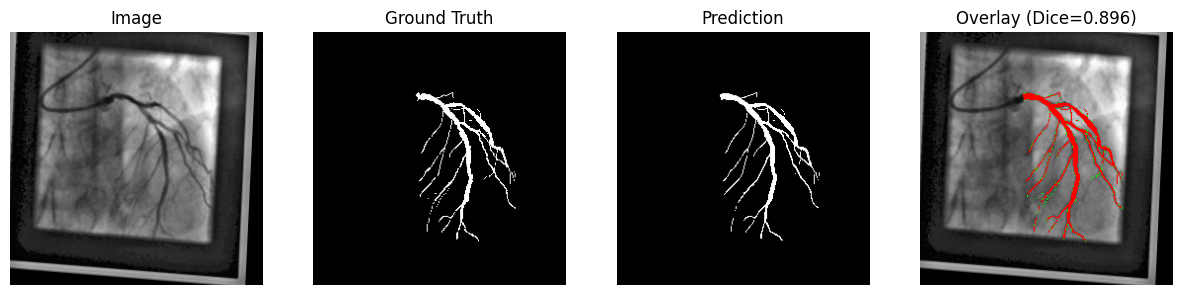

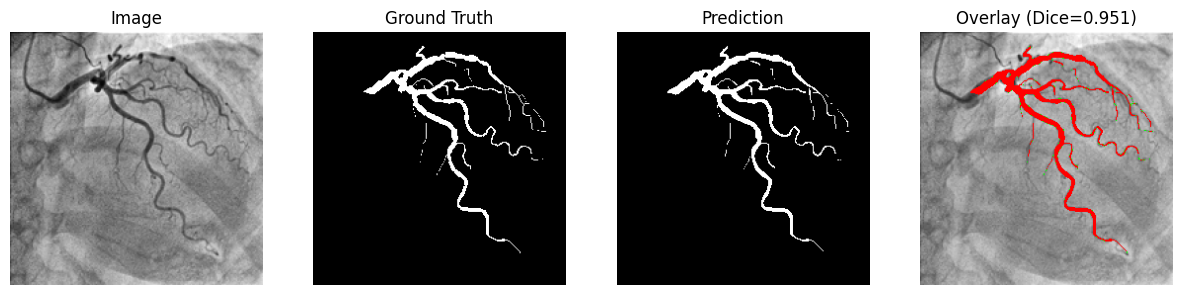

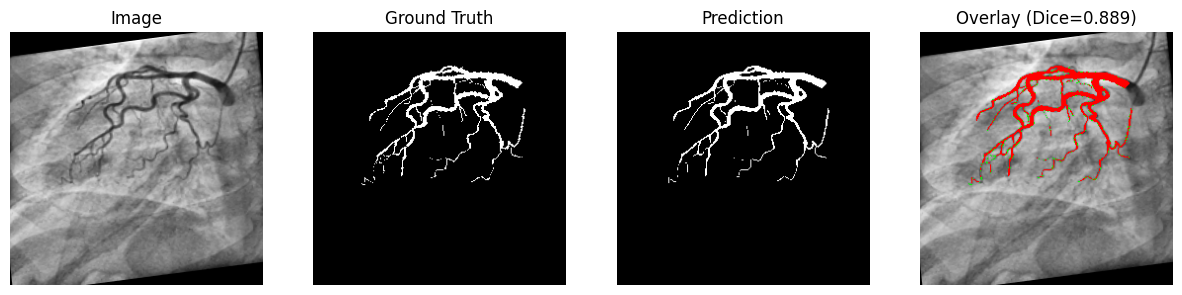

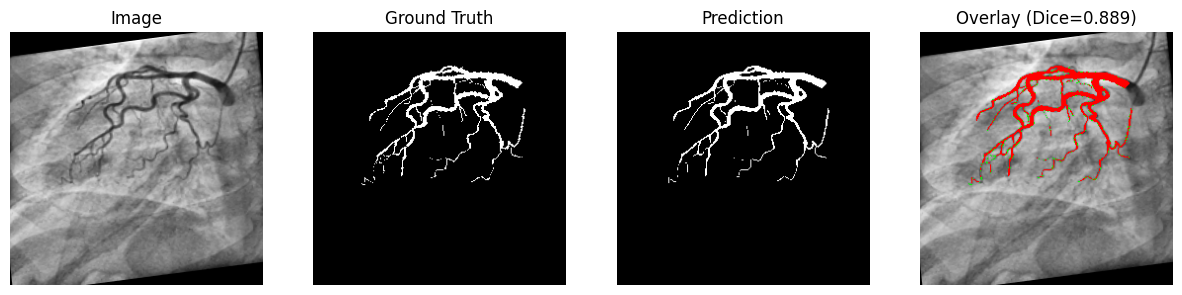

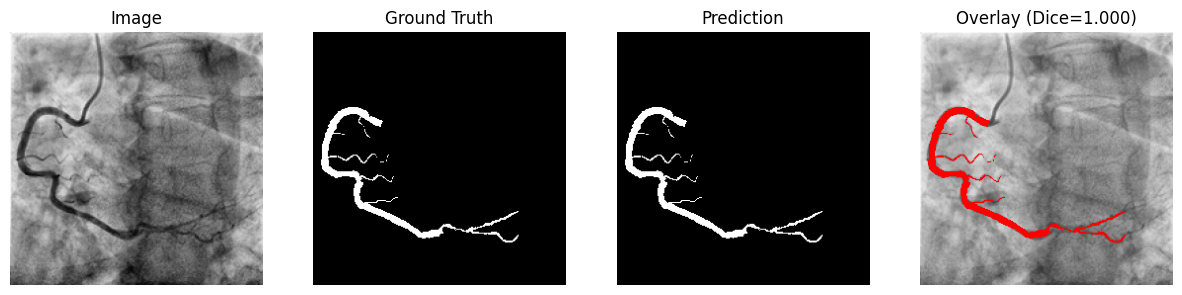

In [9]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
IMG_DIR  = Path("/kaggle/working/nnUNet_raw/Dataset001_AngioPHOTO/imagesTs")
PRED_DIR = Path("/kaggle/working/predictions_fold0")
GT_DIR   = Path("/kaggle/working/angiophoto/AngioPHOTO_split/labelsTs")

images = sorted(IMG_DIR.glob("*_0000.png"))

for _ in range(5):  # show 5 examples
    img_path = random.choice(images)
    case_id = img_path.stem.replace("_0000", "")
    
    pred_path = PRED_DIR / f"{case_id}.png"
    gt_path   = GT_DIR / f"{case_id}.png"

    img  = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    pred = cv2.imread(str(pred_path), cv2.IMREAD_GRAYSCALE)
    gt   = cv2.imread(str(gt_path), cv2.IMREAD_GRAYSCALE)

    if pred is None or gt is None:
        print("Missing file for:", case_id)
        continue

    # Ensure binary
    pred = (pred > 0).astype(np.uint8)
    gt   = (gt > 0).astype(np.uint8)

    # Compute Dice
    intersection = np.sum(pred * gt)
    dice = (2. * intersection) / (np.sum(pred) + np.sum(gt) + 1e-8)

    # Plot
    plt.figure(figsize=(15,4))

    plt.subplot(1,4,1)
    plt.title("Image")
    plt.imshow(img, cmap="gray")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.title("Ground Truth")
    plt.imshow(gt, cmap="gray")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.title("Prediction")
    plt.imshow(pred, cmap="gray")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.title(f"Overlay (Dice={dice:.3f})")
    overlay = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    overlay[gt == 1] = [0, 255, 0]      # GT = green
    overlay[pred == 1] = [255, 0, 0]    # Prediction = red
    plt.imshow(overlay)
    plt.axis("off")

    plt.show()

In [10]:
import cv2
import numpy as np
from pathlib import Path

PRED_DIR = Path("/kaggle/working/predictions_fold0")
GT_DIR   = Path("/kaggle/working/angiophoto/AngioPHOTO_split/labelsTs")

dice_scores = []

for gt_path in GT_DIR.glob("*.png"):
    case_id = gt_path.stem
    pred_path = PRED_DIR / f"{case_id}.png"
    
    if not pred_path.exists():
        continue
        
    gt = cv2.imread(str(gt_path), cv2.IMREAD_GRAYSCALE)
    pred = cv2.imread(str(pred_path), cv2.IMREAD_GRAYSCALE)

    gt = (gt > 0).astype(np.uint8)
    pred = (pred > 0).astype(np.uint8)

    intersection = np.sum(gt * pred)
    dice = (2. * intersection) / (np.sum(gt) + np.sum(pred) + 1e-8)
    dice_scores.append(dice)

print("Average Dice:", np.mean(dice_scores))
print("Std Dice:", np.std(dice_scores))

Average Dice: 0.8690936573721575
Std Dice: 0.15083093640696313


In [11]:
import cv2
import numpy as np
from pathlib import Path

PRED_DIR = Path("/kaggle/working/predictions_fold0")
GT_DIR   = Path("/kaggle/working/angiophoto/AngioPHOTO_split/labelsTs")

results = []

for gt_path in sorted(GT_DIR.glob("*.png")):
    case_id = gt_path.stem
    pred_path = PRED_DIR / f"{case_id}.png"
    
    if not pred_path.exists():
        continue
        
    gt = cv2.imread(str(gt_path), cv2.IMREAD_GRAYSCALE)
    pred = cv2.imread(str(pred_path), cv2.IMREAD_GRAYSCALE)

    gt = (gt > 0).astype(np.uint8)
    pred = (pred > 0).astype(np.uint8)

    intersection = np.sum(gt * pred)
    dice = (2. * intersection) / (np.sum(gt) + np.sum(pred) + 1e-8)
    
    results.append((case_id, dice))

results = sorted(results, key=lambda x: x[1])
for r in results:
    print(r)

('angio_0032', np.float64(0.5268052516396969))
('angio_0036', np.float64(0.5696737044124005))
('angio_0055', np.float64(0.6397562833194217))
('angio_0004', np.float64(0.6905508284808322))
('angio_0014', np.float64(0.8568051999195258))
('angio_0076', np.float64(0.8658095620713825))
('angio_0088', np.float64(0.8893266475628773))
('angio_0070', np.float64(0.8961748633855297))
('angio_0082', np.float64(0.9108561341554972))
('angio_0065', np.float64(0.9196222455384688))
('angio_0029', np.float64(0.9292461236839614))
('angio_0030', np.float64(0.951298701297157))
('angio_0012', np.float64(0.9985752086281324))
('angio_0015', np.float64(0.9994155464625959))
('angio_0028', np.float64(0.9997695321479609))
('angio_0005', np.float64(0.9999999999975961))
('angio_0018', np.float64(0.9999999999977905))
('angio_0081', np.float64(0.999999999998008))


In [13]:
import shutil

# Path to the folder you want to download
folder_to_zip = "/kaggle/working"

# Name of the zip file (without .zip)
zip_path = "/kaggle/working/angiophotoTRA"

# Create zip file
shutil.make_archive(zip_path, 'zip', folder_to_zip)

print("✅ Zip file created at:", zip_path + ".zip")

✅ Zip file created at: /kaggle/working/angiophotoTRA.zip


In [16]:
!zip -r angio_ALL_RESULTS.zip \
/kaggle/working/predictions_fold0 \
/kaggle/working/nnUNet_results \
/kaggle/working/nnUNet_raw

  adding: kaggle/working/predictions_fold0/ (stored 0%)
  adding: kaggle/working/predictions_fold0/angio_0032.png (deflated 0%)
  adding: kaggle/working/predictions_fold0/angio_0012.png (deflated 1%)
  adding: kaggle/working/predictions_fold0/angio_0004.png (stored 0%)
  adding: kaggle/working/predictions_fold0/angio_0070.png (deflated 1%)
  adding: kaggle/working/predictions_fold0/angio_0018.png (stored 0%)
  adding: kaggle/working/predictions_fold0/angio_0081.png (stored 0%)
  adding: kaggle/working/predictions_fold0/predict_from_raw_data_args.json (deflated 43%)
  adding: kaggle/working/predictions_fold0/angio_0055.png (deflated 0%)
  adding: kaggle/working/predictions_fold0/angio_0088.png (deflated 1%)
  adding: kaggle/working/predictions_fold0/dataset.json (deflated 35%)
  adding: kaggle/working/predictions_fold0/angio_0029.png (deflated 1%)
  adding: kaggle/working/predictions_fold0/angio_0030.png (stored 0%)
  adding: kaggle/working/predictions_fold0/angio_0082.png (deflated 0%)